### Importamos las librerías necesarias

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Iniciamos con la lectura de los datos

In [29]:
df = pd.read_excel("real_estate_data.xlsx", index_col = [0])

#### Formateo de los nombres de las columnas para remover espacios

In [30]:
def format_cols_spaces(columns):
  return {key:key.replace(" ","_") for key in columns}

### Funcion para estandarizar la data

In [31]:

def standardize_data(data):
    new_data = data.copy()
    for col in new_data.columns:
        new_data[col] = (new_data[col] - new_data[col].mean()) / new_data[col].std()
    return new_data

### Formateamos la data y normalizamos los datos de train y test

In [32]:
columns_replace = format_cols_spaces(df.columns)
df = df.rename(columns = columns_replace)
df_train = df.loc[0:315].copy()
df_test = df.loc[316:].copy()
mean_std = df_train.describe().loc[["mean","std"]]
df_train_norm = standardize_data(df_train)
df_test_norm = df_test.apply(lambda x: (x - mean_std.loc["mean"]) / mean_std.loc["std"], axis = 1)


### Creamos la clase NeuralNetwork

In [33]:
class NeuralNetwork:
  def __init__(self, activation, eps, learning_rate, epochs, for_train):

    #Inicializacion de pesos
    self.W1 = np.random.random((5,6))
    self.b1 = np.random.random((5,1))

    self.W2 = np.random.random((1,5))
    self.b2 = np.random.random((1,1))

    #Para ver si devolvemos la loss history o solo loss_history[-1]
    self.for_train = for_train

    #Inicializacion de hiperparametros
    self.eps = eps
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.activation = self.sigmoid if activation == "sigmoid" else self.relu

  def relu(self,X):
    return np.maximum(0,X)
  
  def sigmoid(self,X):
    return 1/(1+np.exp(-X))

  def forward(self, X):
    zi = self.W1@X + self.b1
    zi = self.activation(zi)
    y_hat = self.W2@zi + self.b2
    return y_hat 
  
  def funcion_objetivo(self, X, y):
    return 0.5*np.mean((self.forward(X).T - y)**2)
  
  def numerical_gradient(self, X, y):
      # Calcular el gradiente numérico por cada parámetro
      eps = self.eps
      grads = {}
      for param_name in ["W1", "b1", "W2", "b2"]:
          param = getattr(self, param_name)
          loss_mat = np.zeros_like(param)
          ## For loop para W1
          for i in range(param.shape[0]):
            for j in range(param.shape[1]):
                original_value = param[i, j]
                param[i, j] = original_value + eps
                grad_plus = self.funcion_objetivo(X, y)
                param[i, j] = original_value - eps
                grad_minus = self.funcion_objetivo(X, y)
                param[i, j] = original_value
                loss_mat[i, j] = (grad_plus - grad_minus) / (2 * eps)
          grads[param_name] = loss_mat
      return grads
  
#funcion fit y loop de entrenamiento
  def fit(self, X, y):
    learning_rate = self.learning_rate
    epochs = self.epochs
    # Inicializar historial de pérdidas
    loss_history = []

    # Ciclo de entrenamiento
    for epoch in range(epochs):
        # Calculamos los gradientes
        grads = self.numerical_gradient(X, y)

        # Actualizamos los pesos y bias
        for param_name in ["W1", "b1", "W2", "b2"]:
            param = getattr(self, param_name)
            grad = grads[param_name]
            param -= learning_rate * grad
        loss = self.funcion_objetivo(X, y)
        loss_history.append(loss)
    if self.for_train:
       return loss_history[-1]
    else:
       return loss_history
       



#### Separamos ambos datasets en X e y

In [54]:
df_train_X = df_train.drop(['Y_house_price_of_unit_area'], axis = 1)
df_train_y = df_train[['Y_house_price_of_unit_area']]

df_train_X_norm = df_train_norm.drop(['Y_house_price_of_unit_area'], axis = 1)
df_train_y_norm = df_train_norm[['Y_house_price_of_unit_area']]

df_test_X = df_test.drop(['Y_house_price_of_unit_area'], axis = 1)
df_test_y = df_test[['Y_house_price_of_unit_area']]

df_test_X_norm = df_test_norm.drop(['Y_house_price_of_unit_area'], axis = 1)


#### Nos guardamos los valores del Dataset sin las columnas y trasponemos para que queden compatibles las dimensiones con los pesos y biases.
- Aclaración:
No normalizamos los y, dado que esos valores queremos mantenerlos.
Lo que normalizamos son los X de train para que ningún feature quede
dominante solo por una diferencia de escala.

In [66]:
train_X_values = df_train_X.values.T
train_y_values = df_train_y.values

train_X_norm_values = df_train_X_norm.values.T
test_X_norm_values = df_test_X_norm.values.T

test_y_values = df_test_y.values



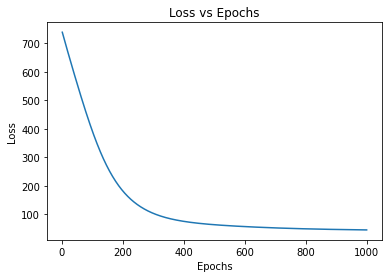

In [36]:
neural_1 = NeuralNetwork("sigmoid", 0.0001, 0.001, 1000,False)
loss_1 =   neural_1.fit(train_X_norm_values, train_y_values)

epochs = np.arange(1,1001)
plt.plot(epochs, loss_1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

#### Inicializamos el ciclo de entrenamiento.
- Rangos:
- Epsilon (1e-4, 1e-2)
- Learning Rate (1e-4, 1e-2)
- Epochs (10^2,10^5)
- Funciones de activación (ReLu, Sigmoide)

In [38]:
def train_model(eps_range, learning_rate_range, epochs_range):
    training_list = []
    for eps in range(eps_range[0], eps_range[1]):
        for learning_rate in range(learning_rate_range[0], learning_rate_range[1]):
            for epochs in range(epochs_range[0], epochs_range[1]):
                for activation in ["sigmoid", "relu"]:
                    neural1 = NeuralNetwork(activation, 10**(-eps), 10**(-learning_rate), 10**(epochs), True)
                    loss = neural1.fit(train_X_norm_values, train_y_values)
                    training_list.append([eps, learning_rate, epochs, activation, loss])
    return training_list


In [39]:
training_list_1 = train_model((2,5), (2,5), (2,5))
training_list_2 = train_model((2,5), (1,5), (2,5))

#### Guardamos las iteraciones en un dataframe para poder analizarlas

In [40]:
data_loss_1 = pd.DataFrame(training_list_1, columns = ["eps", "learning_rate", "epochs", "activation", "loss"])
data_loss_2 = pd.DataFrame(training_list_2, columns = ["eps", "learning_rate", "epochs", "activation", "loss"])

In [41]:
data_loss_1 = data_loss_1.sort_values(by = "loss", ascending = True)
data_loss_1['learning_rate'] = data_loss_1['learning_rate'].apply(lambda x: 10**(-x))
data_loss_1['eps'] = data_loss_1['eps'].apply(lambda x: 10**(-x))
data_loss_1['epochs'] = data_loss_1['epochs'].apply(lambda x: 10**(x))
data_loss_1.reset_index(inplace = True, drop = True)

In [42]:
data_loss_2 = data_loss_2.sort_values(by = "loss", ascending = True)
data_loss_2['learning_rate'] = data_loss_2['learning_rate'].apply(lambda x: 10**(-x))
data_loss_2['eps'] = data_loss_2['eps'].apply(lambda x: 10**(-x))
data_loss_2['epochs'] = data_loss_2['epochs'].apply(lambda x: 10**(x))
data_loss_2.reset_index(inplace = True, drop = True)

In [43]:
data_loss_1

,eps,learning_rate,epochs,activation,loss
0,0.0100,0.0100,10000,sigmoid,24.793836
1,0.0001,0.0100,10000,sigmoid,24.870604
2,0.0010,0.0100,10000,sigmoid,25.493315
3,0.0100,0.0100,10000,relu,26.957123
4,0.0010,0.0100,10000,relu,27.968787
5,0.0001,0.0100,10000,relu,28.494270
6,0.0001,0.0010,10000,relu,29.181692
7,0.0100,0.0100,1000,sigmoid,29.638118
8,0.0001,0.0100,1000,sigmoid,29.792508
9,0.0010,0.0010,10000,relu,30.047732


In [53]:
data_loss_2

,eps,learning_rate,epochs,activation,loss
0,0.0100,0.10,10000,sigmoid,2.242778e+02
1,0.0001,0.10,10000,sigmoid,2.285404e+02
2,0.0010,0.01,10000,sigmoid,2.418299e+02
3,0.0100,0.01,10000,sigmoid,2.426358e+02
4,0.0001,0.10,1000,sigmoid,2.437575e+02
...,...,...,...,...,...
67,0.0001,0.10,100,relu,2.329101e+82
68,0.0010,0.10,10000,relu,5.064376e+83
69,0.0100,0.10,1000,relu,3.725068e+107
70,0.0010,0.10,1000,relu,5.532938e+113


##### Como podemos ver en data_loss_2 el minimo valor encontrado es mejor que en data_loss_1. Esto sucede porque data_loss_2 incluye un learing rate que es 0.1 el cual data_loss_1 no incluye. Este learning rate es un poco mas "extremo", luego con funciones de activacion como ReLu los valores no convergen. Sin embargo el valor minimo de la loss con sigmoide es menor que el de data_loss_1.

In [68]:
neural_best = NeuralNetwork("sigmoid", 0.01, 0.1, 10000, True)
loss_best = neural_best.fit(train_X_norm_values, train_y_values)

In [71]:
loss_best

22.420517534905958

In [70]:
preds = neural_best.forward(test_X_norm_values)
preds = preds.T
preds
mse = np.mean((preds - test_y_values)**2)
print(mse)

51.45103153117248
